In [1]:
import os
import glob
import rasterio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/home/andres/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Temperature differences
df = pd.read_csv('./netatmo_stations/diff.csv', delimiter=',')
df.head()

,station,temp_diff,lon,lat
0,70:ee:50:01:60:78,0.073386,-0.888513,41.676094
1,70:ee:50:01:cf:12,1.353017,-0.938232,41.625653
2,70:ee:50:04:ac:ea,0.525579,-1.031000,41.725300
3,70:ee:50:04:b4:36,0.200639,-0.892489,41.677088
4,70:ee:50:04:d3:de,1.304331,-0.864463,41.663082


In [3]:
import pyproj

# Define the CRS for the original (longitude, latitude) and target (projected coordinates)
wgs84 = pyproj.CRS("EPSG:4326")  # WGS84 (longitude, latitude)
utm = pyproj.CRS("EPSG:25830")  # UTM projection (ETRS89 / UTM zone 30N)

# Create a transformer to convert between the two coordinate systems
transformer = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True)

In [4]:
# Apply transformation to each row and modify the DataFrame
df['x'], df['y'] = zip(*df.apply(lambda row: transformer.transform(row['lon'], row['lat']), axis=1))
df.head()

,station,temp_diff,lon,lat,x,y
0,70:ee:50:01:60:78,0.073386,-0.888513,41.676094,675757.042891,4.615968e+06
1,70:ee:50:01:cf:12,1.353017,-0.938232,41.625653,671752.285110,4.610267e+06
2,70:ee:50:04:ac:ea,0.525579,-1.031000,41.725300,663771.088315,4.621151e+06
3,70:ee:50:04:b4:36,0.200639,-0.892489,41.677088,675423.336049,4.616070e+06
4,70:ee:50:04:d3:de,1.304331,-0.864463,41.663082,677794.821735,4.614573e+06


In [5]:
# Go to raster directory
raster_dir = '../data/rasters'
os.chdir(raster_dir)

In [6]:
# List all .tif files
list = glob.glob('*.tif')
list

['Zaragoza_ETRS89_NDTI.tif',
 'Zaragoza_ETRS89_NDVI_scaled_old.tif',
 'interpolation_SVF+IMD+NDVI_scaled.tif',
 'Zaragoza_ETRS89_NDVI_scaled.tif',
 'Zaragoza_ETRS89_MDS05.tif',
 'Zaragoza_ETRS89_LST_LC09_20230815_normalized.tif',
 'Zaragoza_ETRS89_MDT05.tif',
 'Zaragoza_ETRS89_SWIR2_normalized_scaled.tif',
 'Zaragoza_ETRS89_Sky_View_Factor_scaled.tif',
 'Zaragoza_ETRS89_Terrain_Ruggedness_Index.tif',
 'Zaragoza_ETRS89_Imperviousness_Density_normalized_scaled_old.tif',
 'Zaragoza_ETRS89_Imperviousness_Density_normalized.tif',
 'Zaragoza_ETRS89_Sky_View_Factor_scaled_old.tif',
 'Zaragoza_ETRS89_Sky_View_Factor.tif',
 'predictors_skf_imd_ndvi.tif',
 'Zaragoza_ETRS89_SWIR2.tif',
 'Zaragoza_ETRS89_SWIR2_normalized.tif',
 'Zaragoza_ETRS89_MDT05_normalized.tif',
 'Zaragoza_ETRS89_Imperviousness_Density_normalized_scaled.tif',
 'Zaragoza_ETRS89_GLI.tif',
 'Zaragoza_ETRS89_NBAI.tif',
 'Zaragoza_ETRS89_LST_LC09_20230815.tif',
 'Zaragoza_ETRS89_Total_Insolation.tif',
 'Zaragoza_ETRS89_Visible_Sky

EPSG:25830


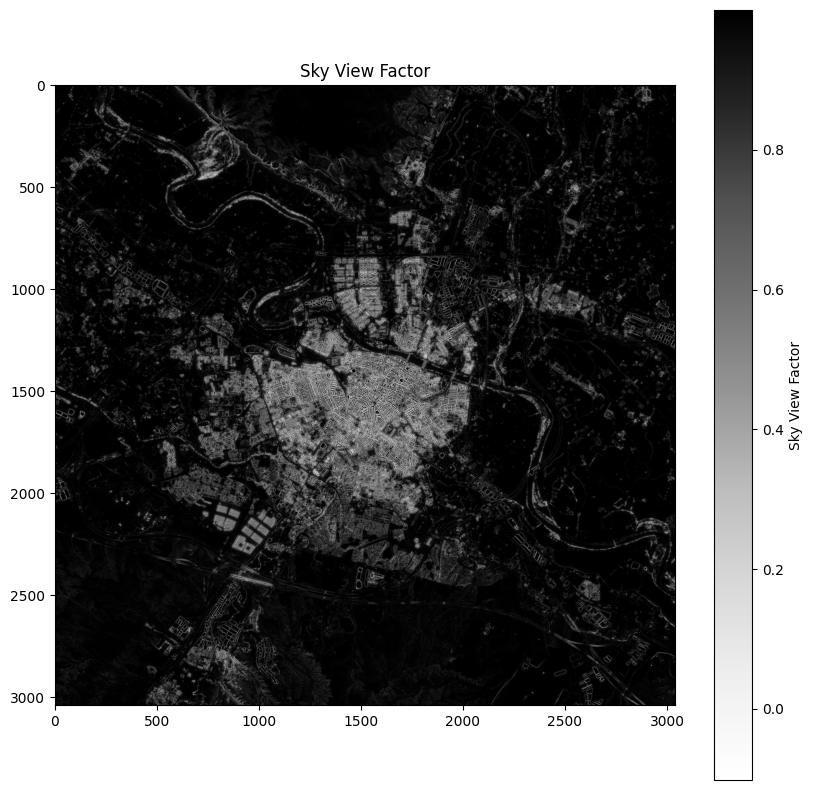

In [7]:
svf_raster_path = 'Zaragoza_ETRS89_Sky_View_Factor.tif'
with rasterio.open(svf_raster_path) as src:
    print(src.crs)
    svf = src.read(1)

    # Extract coordinates for each pixel
    coords = np.array([src.transform * (col, row)
                       for row in range(src.height)
                       for col in range(src.width)])

    lons, lats = coords[:, 0], coords[:, 1]

    # Get SVF values
    svfs = []
    for index, station in df.iterrows():
        # Convert the coordinates (x, y) to row and column
        row, col = src.index(station['x'], station['y'])
        
        # Ensure the indices are within bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            # Read the value of the pixel
            svf_value = svf[row, col]
            svfs.append(svf_value)
        else:
            # Handle out-of-bounds cases
            print(f"Warning: Coordinates ({station['lon']}, {station['lat']}) are out of bounds.")
            svfs.append(np.nan)  # Append NaN for out-of-bounds
    df['svf'] = svfs
    
    
plt.figure(figsize=(10, 10))
plt.imshow(svf, cmap='Grays')
plt.colorbar(label='Sky View Factor')
plt.title(f'Sky View Factor')
plt.show()

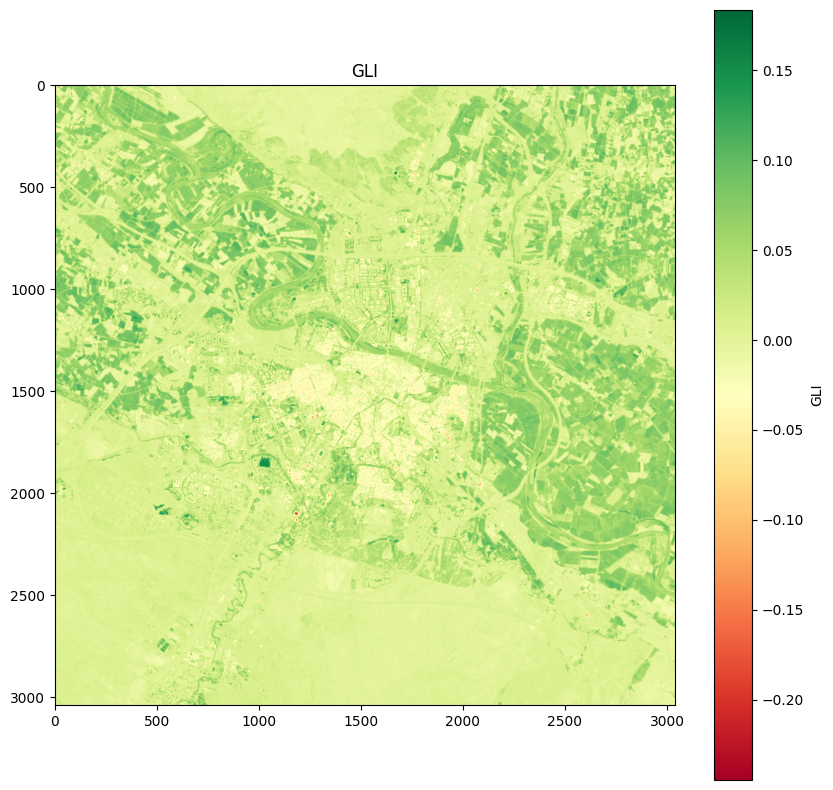

In [8]:
gli_raster_path = 'Zaragoza_ETRS89_GLI.tif'
with rasterio.open(gli_raster_path) as src:
    gli = src.read(
        out_shape=(
            src.count,
            int(3039),
            int(3039)
        ),
        resampling = Resampling.bilinear
    )[0]

    # Get NDVI values
    glis = []
    for index, station in df.iterrows():
        # Convert the coordinates (x, y) to row and column
        row, col = src.index(station['x'], station['y'])
    
        # Ensure the indices are within bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            # Read the value of the pixel
            gli_value = gli[row, col]
            glis.append(gli_value)
        else:
            # Handle out-of-bounds cases
            print(f"Warning: Coordinates ({station['lon']}, {station['lat']}) are out of bounds.")
            glis.append(np.nan)  # Append NaN for out-of-bounds
    df['gli'] = glis
    
plt.figure(figsize=(10, 10))
plt.imshow(gli, cmap='RdYlGn')
plt.colorbar(label='GLI')
plt.title(f'GLI')
plt.show()

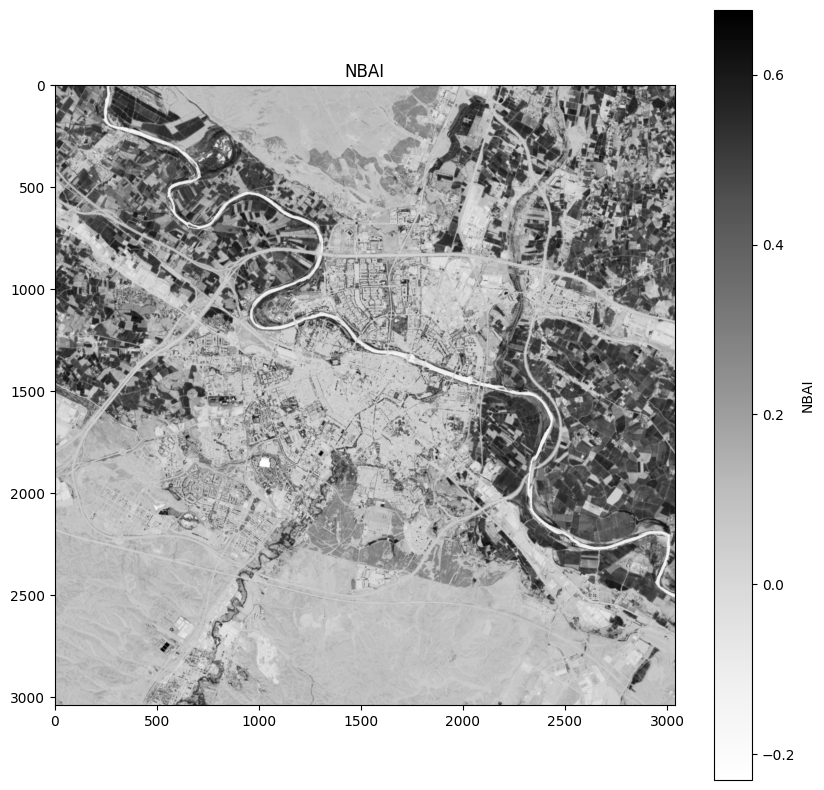

In [9]:
nbai_raster_path = 'Zaragoza_ETRS89_NBAI.tif'
with rasterio.open(nbai_raster_path) as src:
    nbai = src.read(
        out_shape=(
            src.count,
            int(3039), # src.height * scale
            int(3039) # src.width * scale
        ),
        resampling = Resampling.bilinear
    )[0]

    # Get NBAI values
    nbais = []
    for index, station in df.iterrows():
        # Convert the coordinates (x, y) to row and column
        row, col = src.index(station['x'], station['y'])
        
        # Ensure the indices are within bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            # Read the value of the pixel
            nbai_value = nbai[row, col]
            nbais.append(nbai_value)
        else:
            # Handle out-of-bounds cases
            print(f"Warning: Coordinates ({station['lon']}, {station['lat']}) are out of bounds.")
            nbais.append(np.nan)  # Append NaN for out-of-bounds
    df['nbai'] = nbais
    
plt.figure(figsize=(10, 10))
plt.imshow(nbai, cmap='Grays')
plt.colorbar(label='NBAI')
plt.title(f'NBAI')
plt.show()

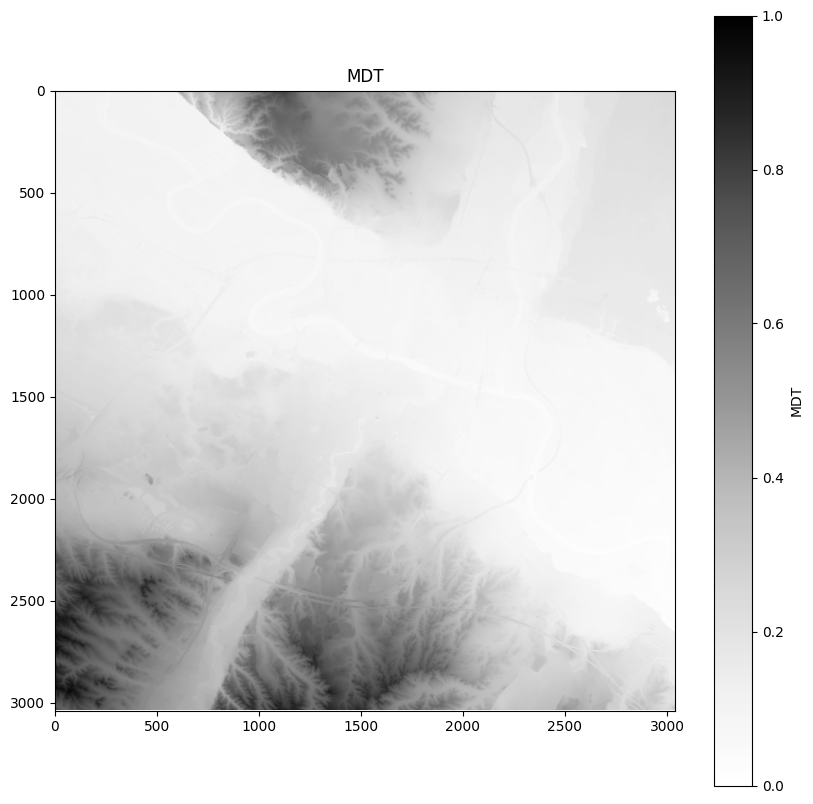

In [10]:
mdt_raster_path = 'Zaragoza_ETRS89_MDT05_normalized.tif'
with rasterio.open(mdt_raster_path) as src:
    mdt = src.read(
        out_shape=(
            src.count,
            int(3039), # src.height * scale
            int(3039) # src.width * scale
        ),
        resampling = Resampling.bilinear
    )[0]

    # Get MDT values
    mdts = []
    for index, station in df.iterrows():
        # Convert the coordinates (x, y) to row and column
        row, col = src.index(station['x'], station['y'])
        
        # Ensure the indices are within bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            # Read the value of the pixel
            mdt_value = mdt[row, col]
            mdts.append(mdt_value)
        else:
            # Handle out-of-bounds cases
            print(f"Warning: Coordinates ({station['lon']}, {station['lat']}) are out of bounds.")
            mdts.append(np.nan)  # Append NaN for out-of-bounds
    df['mdt'] = mdts
    
plt.figure(figsize=(10, 10))
plt.imshow(mdt, cmap='Grays')
plt.colorbar(label='MDT')
plt.title(f'MDT')
plt.show()

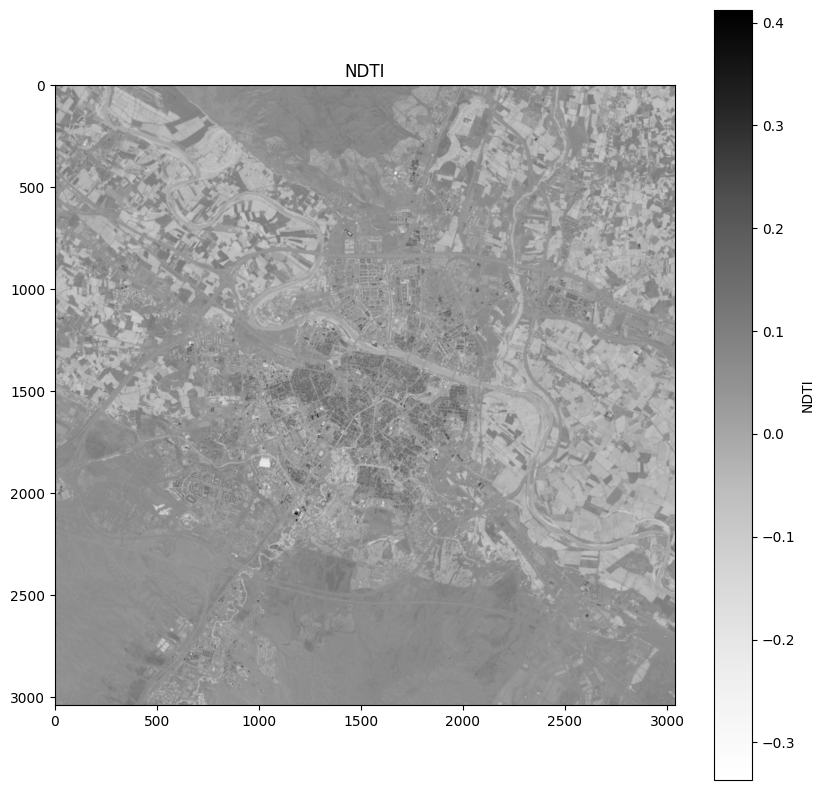

In [11]:
ndti_raster_path = 'Zaragoza_ETRS89_NDTI.tif'
with rasterio.open(ndti_raster_path) as src:
    ndti = src.read(
        out_shape=(
            src.count,
            int(3039), # src.height * scale
            int(3039) # src.width * scale
        ),
        resampling = Resampling.bilinear
    )[0]

    # Get NDTI values
    ndtis = []
    for index, station in df.iterrows():
        # Convert the coordinates (x, y) to row and column
        row, col = src.index(station['x'], station['y'])
        
        # Ensure the indices are within bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            # Read the value of the pixel
            ndti_value = ndti[row, col]
            ndtis.append(ndti_value)
        else:
            # Handle out-of-bounds cases
            print(f"Warning: Coordinates ({station['lon']}, {station['lat']}) are out of bounds.")
            ndtis.append(np.nan)  # Append NaN for out-of-bounds
    df['ndti'] = ndtis
    
plt.figure(figsize=(10, 10))
plt.imshow(ndti, cmap='Grays')
plt.colorbar(label='NDTI')
plt.title(f'NDTI')
plt.show()

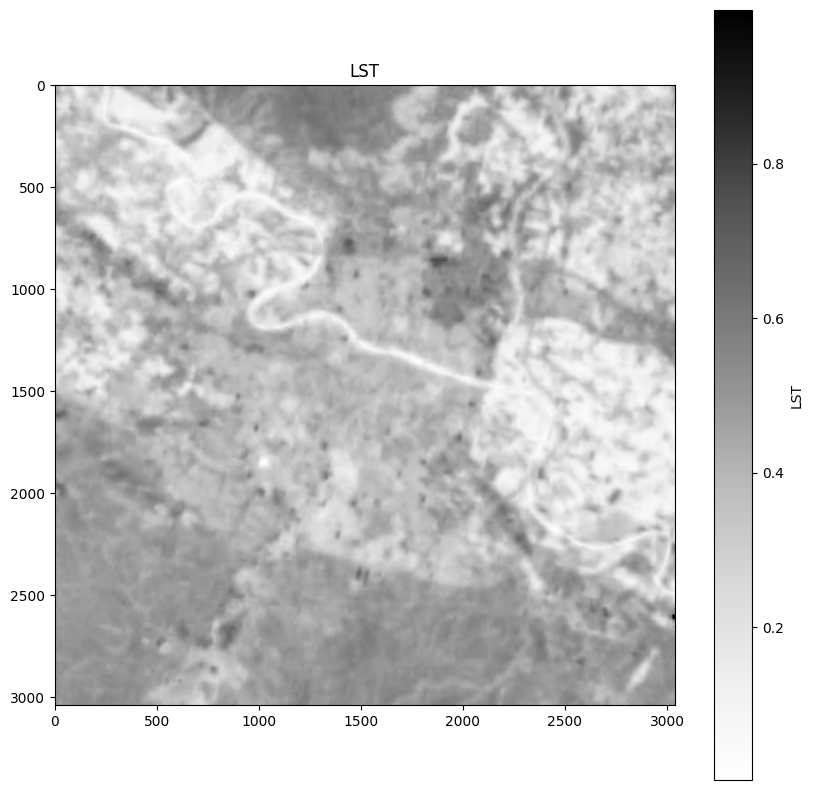

In [12]:
lst_raster_path = 'Zaragoza_ETRS89_LST_LC09_20230815_normalized.tif'
with rasterio.open(lst_raster_path) as src:
    lst = src.read(
        out_shape=(
            src.count,
            int(3039), # src.height * scale
            int(3039) # src.width * scale
        ),
        resampling = Resampling.bilinear
    )[0]

    # Get LST values
    lsts = []
    for index, station in df.iterrows():
        # Convert the coordinates (x, y) to row and column
        row, col = src.index(station['x'], station['y'])
        
        # Ensure the indices are within bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            # Read the value of the pixel
            lst_value = lst[row, col]
            lsts.append(lst_value)
        else:
            # Handle out-of-bounds cases
            print(f"Warning: Coordinates ({station['lon']}, {station['lat']}) are out of bounds.")
            lsts.append(np.nan)  # Append NaN for out-of-bounds
    df['lst'] = lsts
    
plt.figure(figsize=(10, 10))
plt.imshow(lst, cmap='Grays')
plt.colorbar(label='LST')
plt.title(f'LST')
plt.show()

In [13]:
df.head()

,station,temp_diff,lon,lat,x,y,svf,gli,nbai,mdt,ndti,lst
0,70:ee:50:01:60:78,0.073386,-0.888513,41.676094,675757.042891,4.615968e+06,0.295339,0.032525,0.332429,0.085804,0.012414,0.186001
1,70:ee:50:01:cf:12,1.353017,-0.938232,41.625653,671752.285110,4.610267e+06,0.786471,0.059710,0.425414,0.342229,-0.027562,0.377188
2,70:ee:50:04:ac:ea,0.525579,-1.031000,41.725300,663771.088315,4.621151e+06,NaN,NaN,NaN,NaN,NaN,NaN
3,70:ee:50:04:b4:36,0.200639,-0.892489,41.677088,675423.336049,4.616070e+06,0.564394,0.047588,0.428031,0.086900,-0.039257,0.122325
4,70:ee:50:04:d3:de,1.304331,-0.864463,41.663082,677794.821735,4.614573e+06,0.327050,0.018582,0.288496,0.076776,0.048457,0.184769


In [14]:
df = df.drop(columns=['x', 'y'])
df.head()

,station,temp_diff,lon,lat,svf,gli,nbai,mdt,ndti,lst
0,70:ee:50:01:60:78,0.073386,-0.888513,41.676094,0.295339,0.032525,0.332429,0.085804,0.012414,0.186001
1,70:ee:50:01:cf:12,1.353017,-0.938232,41.625653,0.786471,0.059710,0.425414,0.342229,-0.027562,0.377188
2,70:ee:50:04:ac:ea,0.525579,-1.031000,41.725300,NaN,NaN,NaN,NaN,NaN,NaN
3,70:ee:50:04:b4:36,0.200639,-0.892489,41.677088,0.564394,0.047588,0.428031,0.086900,-0.039257,0.122325
4,70:ee:50:04:d3:de,1.304331,-0.864463,41.663082,0.327050,0.018582,0.288496,0.076776,0.048457,0.184769


In [15]:
# Drop NaNs
df = df.dropna()
df.head()

,station,temp_diff,lon,lat,svf,gli,nbai,mdt,ndti,lst
0,70:ee:50:01:60:78,0.073386,-0.888513,41.676094,0.295339,0.032525,0.332429,0.085804,0.012414,0.186001
1,70:ee:50:01:cf:12,1.353017,-0.938232,41.625653,0.786471,0.059710,0.425414,0.342229,-0.027562,0.377188
3,70:ee:50:04:b4:36,0.200639,-0.892489,41.677088,0.564394,0.047588,0.428031,0.086900,-0.039257,0.122325
4,70:ee:50:04:d3:de,1.304331,-0.864463,41.663082,0.327050,0.018582,0.288496,0.076776,0.048457,0.184769
5,70:ee:50:05:61:46,0.866704,-0.934771,41.630554,0.837236,-0.027734,0.048184,0.376798,0.134867,0.358102


In [16]:
df.to_csv('../../zaragoza/data_netatmo.csv', index=False)